# Acquire

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Geospatial Libraries
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
import folium.plugins as plugins
from shapely.geometry import Point, Polygon

# AWS
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

import MVP_Bojado

import warnings
warnings.filterwarnings("ignore")

In [3]:
s3 = boto3.resource('s3')

# Locate the S3 bucket named 'additionaljobinfo'
additional_info = s3.Bucket('additionaljobinfo')

In [4]:
# Connect to Blue-Owl Data's S3 Bucket
s3 = boto3.resource('s3')

# List available bucket names.
for bucket in s3.buckets.all():
    print(bucket.name)

# Connect to the prepared data science job postings.
ds_job_bucket = s3.Bucket('dspreparedjobpostings')

additionaljobinfo
amplify-jobdashboardfront-dev-180611-deployment
dspreparedjobpostings
dsrawjobpostings
sagemaker-jobsearchdashboard
sagemaker-studio-793555146825-q0wiagiqq8r
wdpreparedjobpostings
wdrawjobpostings


In [5]:
# List all available files inside of the S3 bucket
for page in ds_job_bucket.objects.pages():
    for obj in page:
        print(obj.key)

df_ds_tx_prepared.json
df_ds_tx_prepared_backup.json


In [6]:
# Download the prepared file from AWS Bucket
ds_job_bucket.download_file('df_ds_tx_prepared.json', 'df_ds_tx_prepared.json')

In [7]:
# Read in the prepared JSON file
df = pd.read_json('df_ds_tx_prepared.json')

In [8]:
df.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized
0,2021-02-04,Sr. Data Scientist - Payments\nnew,AppFolio,3.9,https://www.indeed.com/rc/clk?jk=0faa5a5171e43...,"Hi, We’re AppFolio.\nWe’re innovators, changem...",Dallas,TX,0,hi appfolio innovator changemakers collaborato...,hi were appfolio\nwere innovators changemakers...,hi were appfolio were innov changemak and coll...,hi were appfolio were innovator changemakers a...
1,2021-02-04,Cross-Product Lead – AI ML Data Engineering\nnew,Dell Technologies,4.0,https://www.indeed.com/rc/clk?jk=e248cbbcde2db...,Cross-Product Lead – AI ML Data Engineering\nJ...,Round Rock,TX,0,crossproduct lead ai ml data engineering join ...,crossproduct lead ai ml data engineering\njoin...,crossproduct lead ai ml data engin join us as ...,crossproduct lead ai ml data engineering join ...
2,2021-02-04,NLP Engineer- Conversational AI\nnew,Sam's Club Technology,3.5,https://www.indeed.com/company/Sam's-Club/jobs...,If you are ready to welcome our new computer o...,Dallas,TX,75202,ready welcome new computer overlord conversati...,if you are ready to welcome our new computer o...,if you are readi to welcom our new comput over...,if you are ready to welcome our new computer o...
3,2021-02-04,Sr. Data Analyst\nnew,Inficare,0.0,https://www.indeed.com/company/Christus-Health...,Client - Christus HealthTitle: Sr. Data Analys...,Irving,TX,75038,client christus healthtitle sr data analystloc...,client christus healthtitle sr data analystloc...,client christu healthtitl sr data analystloc i...,client christus healthtitle sr data analystloc...
4,2021-02-04,"Fellow, Data Engineer\nnew",American Heart Association,3.8,https://www.indeed.com/rc/clk?jk=3df9a5250092e...,**Overview**\n\n**Are you ready to join an org...,Dallas,TX,75219,overview ready join organization relentless fo...,overview\n\nare you ready to join an organizat...,overview are you readi to join an organ where ...,overview are you ready to join an organization...


# Prepare

To create a map of job postings in Texas, we'll need to acquire the coordinates of the job location.

In [9]:
# Create a User-Agent name to use geopy
geolocator = Nominatim(user_agent="Promeos")

# Use the geolocator.geocode to find the latitude and longitude of
# Each (city, state[Texas]) combination

# Test the function using an example
location = geolocator.geocode("Dallas, TX")


# Display the address and latitude/longitude value assigned to Dallas, TX
print(location.address)
print("Latitude: ", location.latitude, "\nLongitude:", location.longitude)

Dallas, Dallas County, Texas, United States
Latitude:  32.7762719 
Longitude: -96.7968559


Each time `geolocator.geocode` is called, it submits a GET request to OpenStreetMap's API. For scalability, we can find the coordinates of each unique city in Texas and store the corresponding latitude and longitude values in a seperate dataframe. The dataframe of coordinates can then be joined onto the original job postings dataframe.

Before creating a loop to find the coordindates of each unique (city, state) let's create a new column called `city_state`. `city_state` will contain the string of the (city, state) name, for example: "Dallas, TX". This is critical to establish now for several reasons.
1. On iteractions 2, 3, 4 of the dashboard project we'll want to include more (city, state) combinations around the United States.
2. Our coordinate getter function is _generalizable_. It can get the coordinates of _any_ (city, state).
3. Reduces the amount of time to acquire the coordinates of each job posting.
4. Reduces the number of API calls we'll need to make to OpenMap's API.
    - If we didn't generalize the loop we would need to make 1,342 API calls. Image if we had more data. Yeah.
    
### City State Column

In [10]:
# Create a new column called 'city_state' that contains the
# city, state as a string. Example: "Dallas, Texas"
df = df.assign(
    # Cast 'city' explicitly to a string datatype. There are
    # a few job postings without cities, where city == 0
    city_state = df['city'].astype('str') + ', ' + df['state']
)

# Display the first 5 rows
df.city_state.head()

0        Dallas, TX
1    Round Rock, TX
2        Dallas, TX
3        Irving, TX
4        Dallas, TX
Name: city_state, dtype: object

### API call comparison: Loop vs. Generalization with a Loop

In [11]:
s_unique_city_states = df.city_state.value_counts()

num_api_calls = s_unique_city_states.sum()
num_unique_api_calls = len(s_unique_city_states)

print((f"Without the generalizing the loop, we would need to make {num_api_calls:,} API calls. " \
       + f"\nUsing the unique (city, state) combinations, we only need {num_unique_api_calls} API calls."))

print("\n'I am speed' - Sonic the Hedgehog")

Without the generalizing the loop, we would need to make 1,342 API calls. 
Using the unique (city, state) combinations, we only need 42 API calls.

'I am speed' - Sonic the Hedgehog


Now that we've created a new column to store the (city, state), we can iterate through `city_state` to get the `longitude` and `latitude` of each job posting.

In [12]:
# Wrap the goelocator.geocode function in a RateLimiter function to
# pause inbetween API calls.
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1/20)

# Create a Series of the unique (city, state) combinations.
city_states = df.city_state.unique()

# Loop through each (city, state) and create a geocode object
geodata = [geocode(location, language="en") for location in city_states]

# Loop through each geocode object and extract the latitude and longitude.
latitudes =  [city.latitude for city in geodata]
longitudes =  [city.longitude for city in geodata]

In [13]:
df_coordinates = pd.DataFrame({'city_state' : city_states,
                               'latitude' : latitudes,
                               'longitude' : longitudes})

In [14]:
df_coordinates

,city_state,latitude,longitude
0,"Dallas, TX",32.776272,-96.796856
1,"Round Rock, TX",30.508235,-97.678893
2,"Irving, TX",32.829518,-96.944218
3,"Austin, TX",30.271129,-97.743700
4,"Dallas-Fort Worth, TX",32.747631,-97.313597
5,"0, TX",31.816038,-99.512099
6,"Fort Worth, TX",32.753177,-97.332746
7,"Lewisville, TX",33.046233,-96.994174
8,"Plano, TX",33.013676,-96.692510
9,"San Antonio, TX",29.424600,-98.495141


Let's upload the geospatial data from our job postings into an S3 bucket named `additionaljobinfo`.

In [15]:
# Save the coordinate data as a CSV
df_coordinates.to_csv('geospatial_data.csv', index=False)

# Locate the S3 bucket named 'additionaljobinfo'
additional_info = s3.Bucket('additionaljobinfo')

In [16]:
# Upload the geospatial file to the additionaljobinfo bucket.
additional_info.upload_file('geospatial_data.csv', 'geospatial_data.csv')

In [17]:
# Verify that the file was uploaded.
for files in additional_info.objects.pages():
    for file in files:
        print(file.key)

ds_grams.json
geospatial_data.csv
soft_skills_cleaned


Fantastic. Now that we have the latitude and longitude for each (city, state), we can join the coordinates dataframe onto the original job postings dataframe.

In [18]:
df.merge(df_coordinates)

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized,city_state,latitude,longitude
0,2021-02-04,Sr. Data Scientist - Payments\nnew,AppFolio,3.9,https://www.indeed.com/rc/clk?jk=0faa5a5171e43...,"Hi, We’re AppFolio.\nWe’re innovators, changem...",Dallas,TX,0,hi appfolio innovator changemakers collaborato...,hi were appfolio\nwere innovators changemakers...,hi were appfolio were innov changemak and coll...,hi were appfolio were innovator changemakers a...,"Dallas, TX",32.776272,-96.796856
1,2021-02-04,NLP Engineer- Conversational AI\nnew,Sam's Club Technology,3.5,https://www.indeed.com/company/Sam's-Club/jobs...,If you are ready to welcome our new computer o...,Dallas,TX,75202,ready welcome new computer overlord conversati...,if you are ready to welcome our new computer o...,if you are readi to welcom our new comput over...,if you are ready to welcome our new computer o...,"Dallas, TX",32.776272,-96.796856
2,2021-02-04,"Fellow, Data Engineer\nnew",American Heart Association,3.8,https://www.indeed.com/rc/clk?jk=3df9a5250092e...,**Overview**\n\n**Are you ready to join an org...,Dallas,TX,75219,overview ready join organization relentless fo...,overview\n\nare you ready to join an organizat...,overview are you readi to join an organ where ...,overview are you ready to join an organization...,"Dallas, TX",32.776272,-96.796856
3,2021-02-04,Software Engineer Specialty - Big Data\nnew,Wells Fargo,3.7,https://www.indeed.com/rc/clk?jk=431c9517bb2f2...,Job Description\n\nImportant Note: During the ...,Dallas,TX,0,job description important note application pro...,job description\n\nimportant note during the a...,job descript import note dure the applic proce...,job description important note during the appl...,"Dallas, TX",32.776272,-96.796856
4,2021-02-03,Data Scientist / Consumer Credit Underwriting ...,Jasper,0.0,https://www.indeed.com/company/Brave-Health./j...,About JasperOur mission at Jasper is to help p...,Dallas,TX,0,jasperour mission jasper help people across u ...,about jasperour mission at jasper is to help p...,about jasperour mission at jasper is to help p...,about jasperour mission at jasper is to help p...,"Dallas, TX",32.776272,-96.796856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,2020-12-22,Machine Learning Operations Engineer (Research...,Houston Mechatronics Inc.,0.0,https://www.indeed.com/rc/clk?jk=8e5cf4f5ca268...,"We are looking for a dedicated, operations-ori...",Webster,TX,77598,looking dedicated operationsorientated enginee...,we are looking for a dedicated operationsorien...,we are look for a dedic operationsorient engin...,we are looking for a dedicated operationsorien...,"Webster, TX",29.537694,-95.122097
1338,2020-12-22,Senior Health Data Analyst - Grant Funded - He...,Fort Bend County,3.4,https://www.indeed.com/rc/clk?jk=23643869c35ba...,Overview:\n\nEnsures that the Health & Human S...,Rosenberg,TX,77471,overview ensures health human service hhs depa...,overview\n\nensures that the health human serv...,overview ensur that the health human servic hh...,overview ensures that the health human service...,"Rosenberg, TX",29.557182,-95.808562
1339,2020-12-22,Data Scientist / Data Engineer,SEVEN,3.8,https://www.indeed.com/rc/clk?jk=ae2fad598ffe3...,Job Description\nSEVEN Networks develops innov...,Marshall,TX,75672,job description seven network develops innovat...,job description\nseven networks develops innov...,job descript seven network develop innov mobil...,job description seven network develops innovat...,"Marshall, TX",32.544776,-94.366100
1340,2020-12-22,Sr Data Analyst,"Corporate Pharmacy Services, Inc.",0.0,https://www.indeed.com/rc/clk?jk=51008664dbe3b...,Sr Data Analyst What You Will Be Doing\n\n\nDe...,Belton,TX,76513,sr data analyst designing report dash board in...,sr data analyst what you will be doing\n\n\nde...,sr data analyst what you will be do design rep...,sr data analyst what you will be doing designi...

Now that all parts of the coordinate fetching process are complete, let's create two separate functions.
1. Acquire geospatial data
2. Merge the geospatial data with the original job posting dataframe.

In [19]:
def get_geodata(df, credentials="Blue-Owl-Data"):
    '''
    This function accepts a dataframe of job postings that has
    the column names: 'city_state' where the values are Example: "Austin, Texas".
    
    Returns a UNIQUE dataframe of each (city, state):
    'city_state' : City and state where the job is located. Example: "Austin, Texas"
    'latitude'   : Latitude coordinate of the city
    'longitude'  : Longitude coordinate of the city
    
    Dependency Requirements:
    import geopy
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter
    
    $ pip install geopandas
    
    
    Parameters
    ----------
    df : pandas.core.DataFrame()
    
    credentials : str, default "Blue-Owl-Data"
        Name of an application needed to request data from
        OpenStreetMap.
        
    Returns
    -------
    df_coordinates : pandas.core.DataFrame() 
    '''
    # Create a User-Agent name to use geopy
    geolocator = Nominatim(user_agent=credentials)
    # Wrap the goelocator.geocode function in a RateLimiter function to
    # pause between API calls.
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1/20)

    # Create a Series of unique (city, state) combinations.
    city_states = df.city_state.unique()

    # Loop through each (city, state) and create a geocode object
    geodata = [geocode(location, language="en") for location in city_states]

    # Loop through each geocode object and extract the latitude and longitude.
    latitudes =  [city.latitude for city in geodata]
    longitudes =  [city.longitude for city in geodata]
    
    # Create a dataframe to store the geodata of each location
    df_coordinates = pd.DataFrame({'city_state' : city_states,
                                   'latitude' : latitudes,
                                   'longitude' : longitudes})
    
    return df_coordinates
    
    
def add_coordinates(df):
    '''
    This function accepts a dataframe of job postings that have
    the column names: 'city' and 'state'.
    
    Returns the original dataframe with new columns:
    'city_state' : City and state where the job is located. Example: "Austin, Texas"
    'latitude'   : Latitude coordinate of the city
    'longitude'  : Longitude coordinate of the city
    
    Dependency Requirements:
    import geopy
    from geopy.geocoders import Nominatim
    from geopy.extra.rate_limiter import RateLimiter
    
    $ pip install geopandas
    
    
    Parameters
    ----------
    df : pandas.core.DataFrame()
        
    Returns
    -------
    df_updated : pandas.core.DataFrame() 
    '''
    # Create a new column called 'city_state' that contains the
    # city, state as a string. Example: "Dallas, Texas"
    df = df.assign(
        # Cast 'city' explicitly to a string datatype. There are
        # a few job postings without a city, where city == 0
        city_state = df['city'].astype('str') + ', ' + df['state']
    )
    
    # Create a dataframe to store geodata of each location
    df_geodata = get_geodata(df)
    df_updated = df.merge(df_geodata)
    return df_updated

In [20]:
add_coordinates(df)

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized,city_state,latitude,longitude
0,2021-02-04,Sr. Data Scientist - Payments\nnew,AppFolio,3.9,https://www.indeed.com/rc/clk?jk=0faa5a5171e43...,"Hi, We’re AppFolio.\nWe’re innovators, changem...",Dallas,TX,0,hi appfolio innovator changemakers collaborato...,hi were appfolio\nwere innovators changemakers...,hi were appfolio were innov changemak and coll...,hi were appfolio were innovator changemakers a...,"Dallas, TX",32.776272,-96.796856
1,2021-02-04,NLP Engineer- Conversational AI\nnew,Sam's Club Technology,3.5,https://www.indeed.com/company/Sam's-Club/jobs...,If you are ready to welcome our new computer o...,Dallas,TX,75202,ready welcome new computer overlord conversati...,if you are ready to welcome our new computer o...,if you are readi to welcom our new comput over...,if you are ready to welcome our new computer o...,"Dallas, TX",32.776272,-96.796856
2,2021-02-04,"Fellow, Data Engineer\nnew",American Heart Association,3.8,https://www.indeed.com/rc/clk?jk=3df9a5250092e...,**Overview**\n\n**Are you ready to join an org...,Dallas,TX,75219,overview ready join organization relentless fo...,overview\n\nare you ready to join an organizat...,overview are you readi to join an organ where ...,overview are you ready to join an organization...,"Dallas, TX",32.776272,-96.796856
3,2021-02-04,Software Engineer Specialty - Big Data\nnew,Wells Fargo,3.7,https://www.indeed.com/rc/clk?jk=431c9517bb2f2...,Job Description\n\nImportant Note: During the ...,Dallas,TX,0,job description important note application pro...,job description\n\nimportant note during the a...,job descript import note dure the applic proce...,job description important note during the appl...,"Dallas, TX",32.776272,-96.796856
4,2021-02-03,Data Scientist / Consumer Credit Underwriting ...,Jasper,0.0,https://www.indeed.com/company/Brave-Health./j...,About JasperOur mission at Jasper is to help p...,Dallas,TX,0,jasperour mission jasper help people across u ...,about jasperour mission at jasper is to help p...,about jasperour mission at jasper is to help p...,about jasperour mission at jasper is to help p...,"Dallas, TX",32.776272,-96.796856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,2020-12-22,Machine Learning Operations Engineer (Research...,Houston Mechatronics Inc.,0.0,https://www.indeed.com/rc/clk?jk=8e5cf4f5ca268...,"We are looking for a dedicated, operations-ori...",Webster,TX,77598,looking dedicated operationsorientated enginee...,we are looking for a dedicated operationsorien...,we are look for a dedic operationsorient engin...,we are looking for a dedicated operationsorien...,"Webster, TX",29.537694,-95.122097
1338,2020-12-22,Senior Health Data Analyst - Grant Funded - He...,Fort Bend County,3.4,https://www.indeed.com/rc/clk?jk=23643869c35ba...,Overview:\n\nEnsures that the Health & Human S...,Rosenberg,TX,77471,overview ensures health human service hhs depa...,overview\n\nensures that the health human serv...,overview ensur that the health human servic hh...,overview ensures that the health human service...,"Rosenberg, TX",29.557182,-95.808562
1339,2020-12-22,Data Scientist / Data Engineer,SEVEN,3.8,https://www.indeed.com/rc/clk?jk=ae2fad598ffe3...,Job Description\nSEVEN Networks develops innov...,Marshall,TX,75672,job description seven network develops innovat...,job description\nseven networks develops innov...,job descript seven network develop innov mobil...,job description seven network develops innovat...,"Marshall, TX",32.544776,-94.366100
1340,2020-12-22,Sr Data Analyst,"Corporate Pharmacy Services, Inc.",0.0,https://www.indeed.com/rc/clk?jk=51008664dbe3b...,Sr Data Analyst What You Will Be Doing\n\n\nDe...,Belton,TX,76513,sr data analyst designing report dash board in...,sr data analyst what you will be doing\n\n\nde...,sr data analyst what you will be do design rep...,sr data analyst what you will be doing designi...

In [21]:
df = add_coordinates(df)

# Exploration

With our coordinate data in hand, let's plot clusters!

In [22]:
# The default crs is the projected coordinate system (EPSG 3857)
m = folium.Map(location=[31.5, -98],
               min_zoom=6,
               zoom_start=6,
               tiles='Stamen Toner',
               max_bounds=True)

# Create a cluster object
mc = plugins.MarkerCluster()

# For each job, sort the job into the appropriate cluster
for index, row in df.iterrows():
    mc.add_child(
        
        folium.Marker(location=[str(row['latitude']), str(row['longitude'])],
                      popup='{}'.format(row['title']),
                      control_scale=True,
                      clustered_marker=True
                     )
    )
    
# Add clusters to the map
m.add_child(mc)

In [23]:
m = folium.Map(location=[31.5, -98],
               min_zoom=6,
               zoom_start=6,
               max_bounds=True)

# Create a cluster object
mc = plugins.MarkerCluster()

# For each job, sort the job into the appropriate cluster
for index, row in df.iterrows():
    mc.add_child(
        
        folium.Marker(location=[str(row['latitude']), str(row['longitude'])],
                      popup='{}'.format(row['title']),
                      control_scale=True,
                      clustered_marker=True
                     )
    )
    
# Add clusters to the map
m.add_child(mc)

## Folium Map Updated
1. Create two boundaries:
- Map Box Boundary to limit view to Texas.
- Thicken Texas' State boarder

2. Update clusters:
- Remove individual job posting markers
- Create a cluster for each city, where the popup returns the Top 5 skills.

In [24]:
m = folium.Map(location=[31.5, -99.8],
               width=750,
               min_zoom=6,
               zoom_start=6,
               max_bounds=True)
m
# # Create a cluster object
# mc = plugins.MarkerCluster()

# # For each job, sort the job into the appropriate cluster
# for index, row in df.iterrows():
#     mc.add_child(
        
#         folium.Marker(location=[str(row['latitude']), str(row['longitude'])],
#                       popup='{}'.format(row['title']),
#                       control_scale=True,
#                       clustered_marker=True
#                      )
#     )
    
# # Add clusters to the map
# m.add_child(mc)

In [29]:
states = gpd.read_file('../states_shapes/cb_2014_us_state_500k.shp')

In [30]:
states[states['NAME'] == 'Texas']['geometry']

49    MULTIPOLYGON Z (((-94.71830 29.72885 0.00000, ...
Name: geometry, dtype: geometry

# Appendix

In [27]:
# Experimenting with geopandas dataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,tokenized,stemmed,lemmatized,city_state,latitude,longitude,geometry
0,2021-02-04,Sr. Data Scientist - Payments\nnew,AppFolio,3.9,https://www.indeed.com/rc/clk?jk=0faa5a5171e43...,"Hi, We’re AppFolio.\nWe’re innovators, changem...",Dallas,TX,0,hi appfolio innovator changemakers collaborato...,hi were appfolio\nwere innovators changemakers...,hi were appfolio were innov changemak and coll...,hi were appfolio were innovator changemakers a...,"Dallas, TX",32.776272,-96.796856,POINT (-96.79686 32.77627)
1,2021-02-04,NLP Engineer- Conversational AI\nnew,Sam's Club Technology,3.5,https://www.indeed.com/company/Sam's-Club/jobs...,If you are ready to welcome our new computer o...,Dallas,TX,75202,ready welcome new computer overlord conversati...,if you are ready to welcome our new computer o...,if you are readi to welcom our new comput over...,if you are ready to welcome our new computer o...,"Dallas, TX",32.776272,-96.796856,POINT (-96.79686 32.77627)
2,2021-02-04,"Fellow, Data Engineer\nnew",American Heart Association,3.8,https://www.indeed.com/rc/clk?jk=3df9a5250092e...,**Overview**\n\n**Are you ready to join an org...,Dallas,TX,75219,overview ready join organization relentless fo...,overview\n\nare you ready to join an organizat...,overview are you readi to join an organ where ...,overview are you ready to join an organization...,"Dallas, TX",32.776272,-96.796856,POINT (-96.79686 32.77627)
3,2021-02-04,Software Engineer Specialty - Big Data\nnew,Wells Fargo,3.7,https://www.indeed.com/rc/clk?jk=431c9517bb2f2...,Job Description\n\nImportant Note: During the ...,Dallas,TX,0,job description important note application pro...,job description\n\nimportant note during the a...,job descript import note dure the applic proce...,job description important note during the appl...,"Dallas, TX",32.776272,-96.796856,POINT (-96.79686 32.77627)
4,2021-02-03,Data Scientist / Consumer Credit Underwriting ...,Jasper,0.0,https://www.indeed.com/company/Brave-Health./j...,About JasperOur mission at Jasper is to help p...,Dallas,TX,0,jasperour mission jasper help people across u ...,about jasperour mission at jasper is to help p...,about jasperour mission at jasper is to help p...,about jasperour mission at jasper is to help p...,"Dallas, TX",32.776272,-96.796856,POINT (-96.79686 32.77627)


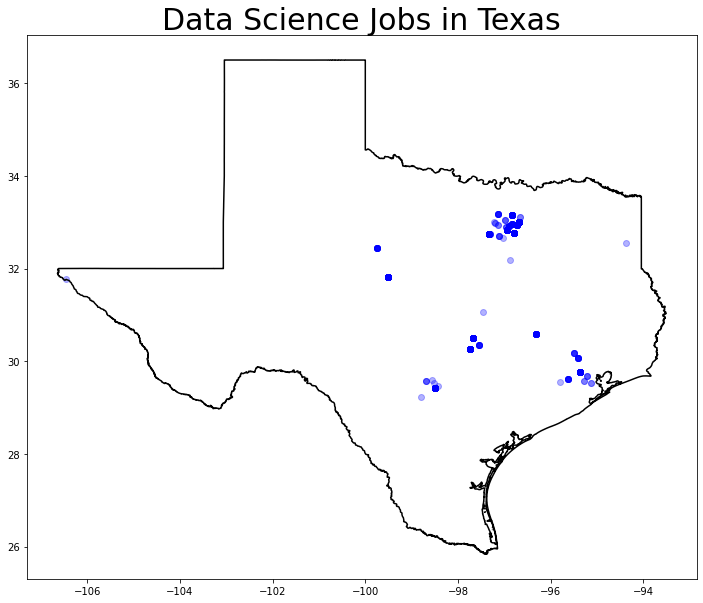

In [28]:
states = gpd.read_file('../states_shapes/cb_2014_us_state_500k.shp')

def df_to_gdf(df):
    coordinates = df[['latitude', 'longitude']].astype(float).values
    coordinates = pd.DataFrame(data = coordinates)
    coordinates.columns = ['lat', 'lon']
    coordinates = [Point(xy) for xy in zip(coordinates.lon, coordinates.lat)]
    geo_df = gpd.GeoDataFrame(df, crs={'init': 'epsg:3857'}, geometry=coordinates)
    return geo_df

# loading world map
#earth_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#base = earth_map.plot(color='white', edgecolor='black', figsize = (20,25))

texas = states[states['NAME'] == 'Texas'].boundary.plot(figsize=(12, 12), edgecolor='k')

# creating dataframe for geoplot
texas_data = df_to_gdf(df)

# plotting map


ax = texas_data.plot(ax=texas,
                     marker = 'o',
                     color = 'blue',
                     alpha=.3)

plt.title('Data Science Jobs in Texas', fontsize=30)
plt.show()